<h1> Personalitics [MBTI Classifier]</h1>

# 1. Project Overview

Personalitics is a text analytics project that aims to know if it's possible to classify a person based on his/her social media posts. To create an analytical model, this project will use a pre-labeled web scraped data from <i>16Personalities' Discussion Forum</i>. 
<br>

> Credits: 16personalities.com

<b> What is 16Personalities? </b>
<br>


16Personalities is a web platform that helps people know more about their personality type. They are using the Myers–Briggs Type Indicator (MBTI) model on their personality type test to evaluate an individual. They have a discussion forum which allows their members to ask questions and discuss a particular topic.
<br>

<b> MBTI Overview: </b>

MBTI is an introspective self-report questionnaire indicating differing psychological preferences in how people perceive the world and make decisions. MBTI divides everyone into 16 distinct personality types across 4 axis:

*  Introversion (I) – Extroversion (E)
*  Intuition (N) – Sensing (S)
*  Thinking (T) – Feeling (F)
*  Judging (J) – Perceiving (P)

## 1.1 Sources/Useful Links

<b>Sources:</b> <br>
https://en.wikipedia.org/wiki/Myers%E2%80%93Briggs_Type_Indicator

<b>Useful Links:</b><br>
https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/ <br>
https://www.16personalities.com/articles/our-theory

## 1.2 Problem Statement

*  Identify what is the MBTI of a post owner from 16Personalities' Discussion Forum.
*  This could be very useful for various organizations, especially on their HR analytics / Marketing teams. 
<i>ie.</i> Help them develop a prior knowledge on their Job Applicants by researching Job Applicants' social media posts. Or help them taylor cohorts for their marketing campaigns.

## 1.3 Objective(s)

* The main objective of this project is to provide a probability that a post belongs to a particular personality type (among the 16 personalities).

# 2. Machine Learning Problem

## 2.1 Data

### 2.1.1 Data Overview

<b> Data Gathering: </b> <br>
<p> 
- The data was gathered from Personalitycafe's Forum, 16personalities' Forum, and Kaggle. I collected each of the dataset thru web scraping, except for the dataset from Kaggle. <br><br>
- Datasets:  <br>
1. data_discussion_16personalities.csv [Size: N mb]<br>
2. data_personalitycafe.csv [Size: N mb]<br>
3. data_pub_16personalities.csv. [Size: N mb]<br><br>

Note: Although there are various features on each dataset, I decided to use only the text data to normalize the feature set and be able to test it on my use case. <br><br>
<b> Data Dictionary: </b> <br>
    xxxxx

## 2.2 Mapping to a Machine Learning Problem

### 2.2.1 Type of Machine Learning Problem

This is a multiclass classification problem because we are going to to classify a post either of the 16 personalities.

### 2.2.2 Performance Metric

<b>Metric(s):</b><br>
* Log-loss
* F1 Score 

<p>We'll use Log Loss to see the probability of a post belonging to a category. (We will see later why I chose F1 Score as a metric.)</p>

## 2.3 Train and Test Set Configuration

We are going to randomly split the data into 70:30 ratio.

## 3. Exploratory Data Analysis

In [32]:
# Loading the required modules
import re
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns


### 3.0.1 Loading the Datasets

In [548]:
df_16p_disc = pd.read_csv('../output/aggregated/data_discussion_16personalities.csv')
df_16p_pub = pd.read_csv('../output/aggregated/data_pub_16personalities.csv')
df_16p_disc = df_16p_disc.rename({'sub-answerBody': 'comment', 'sub-type': 'type'}, axis=1)
df_16p_pub = df_16p_pub.rename({'child_text': 'comment', 'user_type': 'type'}, axis=1)
df_ps_cafe = pd.read_csv('../output/aggregated/data_personalitycafe.csv')
df_ps_cafe = df_ps_cafe.rename({'child_text': 'comment', 'user_type': 'type'}, axis=1)
df = pd.concat([df_16p_disc, df_16p_pub, df_ps_cafe])

In [556]:
# Show a subset of our dataset
df.head()

,comment,type
0,I wanna write a little story; because reading ...,INFP
1,"caly, goddess of love wrote:my friend is gonna...",INTP
2,1. Fix the error\r\n2. Ideal weight for medica...,INFP
3,"There are an equal number of pros and cons, to...",INTJ
4,INTJ: The Three-Eyed-Raven (Game of Thrones)\r...,ISTJ


In [557]:
# How many NULL values do we have?
df.isna().sum()

comment    9
type       0
dtype: int64

In [558]:
# Show the high level statistics of our dataset
df.describe()

,comment,type
count,34470,34479
unique,34290,16
top,,INFP
freq,11,7484


In [562]:
# Show the unique values on our target column
print('Unique Values of the target column:', df['type'].unique().tolist())

Unique Values of the target column: ['INFP', 'INTP', 'INTJ', 'ISTJ', 'ENTP', 'ENFJ', 'ENFP', 'INFJ', 'ENTJ', 'ISFP', 'ISTP', 'ESFJ', 'ISFJ', 'ESFP', 'ESTJ', 'ESTP']


## 3.1  Target Variable Analysis

### 3.1.1 Check the Target Column's Distribution

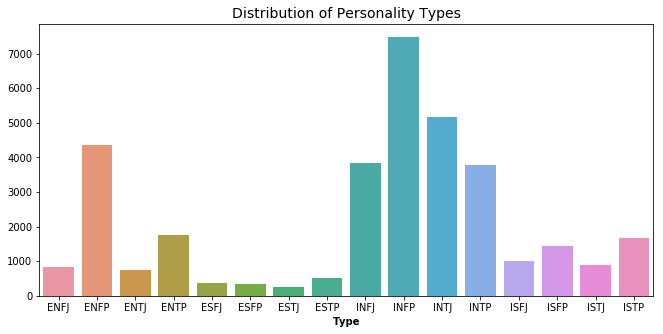

In [564]:
tmp_data_16p_dis = pd.DataFrame(df['type'].value_counts().reset_index().rename({'index': 'type', 'type': 'freq.'}, axis=1)).sort_values(by='type')
cmap = sns.color_palette("Accent", n_colors=16) 
cmap = dict(zip(df['type'].values, cmap))
plt.figure(figsize=(11, 5))
plt.title('Distribution of Personality Types', fontsize=14)
sns.barplot(data=tmp_data_16p_dis, x='type', y='freq.')
plt.ylabel('')
plt.xlabel('Type', fontweight='bold')
plt.show()

<b>Observation(s):<b> <br>
*  Our dataset was suffering from class imbalance issue.
*  Majority of the datapoints belongs to INFP, followed by INTJ.
*  Among Extraverts, ENFP has the most number of datapoints.

In [565]:
type_global_distrib = {'ISFJ': 13.8, 'ESFJ': 12.3, 'ISTJ': 11.6, 'ISFP': 8.8,
                       'ESTJ': 8.7, 'ESFP': 8.5, 'ENFP': 8.1, 'ISTP': 5.4, 
                       'INFP': 4.4, 'ESTP': 4.3, 'INTP': 3.3, 'ENTP': 3.2, 
                       'ENFJ': 2.5, 'INTJ': 2.1, 'ENTJ': 1.8, 'INFJ': 1.5}

# Creating a DataFrame for the Global Data Representation
type_global_distrib_val = list(map(lambda x: x/100, type_global_distrib.values()))
type_global_distrib_col = type_global_distrib.keys()
global_type = pd.DataFrame([type_global_distrib_col, type_global_distrib_val]).T
global_type.columns = ['type', 'freq.']
global_type = global_type.sort_values(by='type')
global_type['freq.'] = global_type['freq.'] * tmp_data_16p_dis['freq.'].sum()

### 3.1.2 Comparing our Dataset Distribution to the Global Data

Since MBTI itself is an active research area, there are lots of available resources of this domain that can be found on the internet. Because of that, we have a downloaded data of the Global Representation of 16 personality types that we can compare to our Dataset. This will enable use to develop a prior knowledge about the problem that we are trying to solve.

> Credits: <a href="https://www.careerplanner.com/MB2/TypeInPopulation.cfm">Career Planner</a>

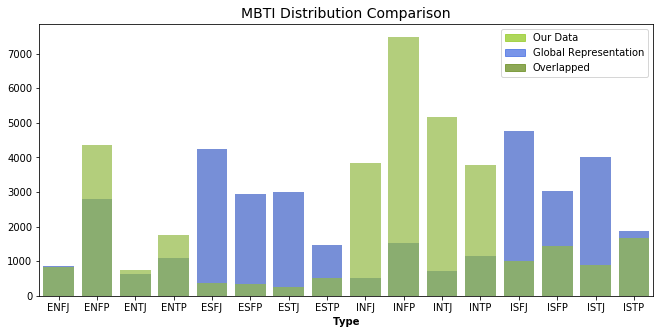

In [566]:
green_patch = mpatches.Patch(color='yellowgreen', label='Our Data', alpha=0.8)
blue_patch = mpatches.Patch(color='royalblue', label='Global Representation', alpha=0.7)
overlap_patch = mpatches.Patch(color='olivedrab', label='Overlapped', alpha=0.77)

plt.figure(figsize=(11, 5))
plt.title('MBTI Distribution Comparison', fontsize=14)
sns.barplot(data=global_type, x='type', y='freq.', color='royalblue', alpha=0.8, label='Global Representation')
sns.barplot(data=tmp_data_16p_dis, x='type', y='freq.', color='yellowgreen', alpha=0.7, label='Our Data')
plt.legend(handles=[green_patch, blue_patch, overlap_patch])
plt.xlabel('Type', fontweight='bold')
plt.ylabel('')
plt.show()

<b>Observation(s):<b>
*  The distribution of our data does not follow the distribution of the global data representation.
*  Lots of Intuitive Introverts was present in our data. I think social media is their main medium for "socializing" and for reflecting their thoughts/opinion (or an excuse to physical contact?). 
*  In contrast, a mix of Sensor (Extravert/Introverts) is less frequent in our dataset. I think this is because of their Sensor nature which makes them busy in other things like physical/outdoor activities.    

### 3.1.3 Slicing the Target Column

Let us find out if using other representation of our target column will help us ease the class imbalance. ie. 
<br> Aggregating into the 4 personality aspects: 


A.) Mind (Introvert or Extravert?)<br>
B.) Energy (Sensing or Intuition?)<br>
C.) Nature (Thinking or Feeling?)<br>
D.) Tactics (Perception or Judging?)<br>


If you haven't read the theory in the link provided at Section 1.1 (Sources/Useful Links), please do so to understand more about the aforementioned terminologies.

In [567]:
df['I-E'] = df['type'].str.contains('I').astype(int)
df['N-S'] = df['type'].str.contains('N').astype(int)
df['T-F'] = df['type'].str.contains('T').astype(int)
df['J-P'] = df['type'].str.contains('J').astype(int)

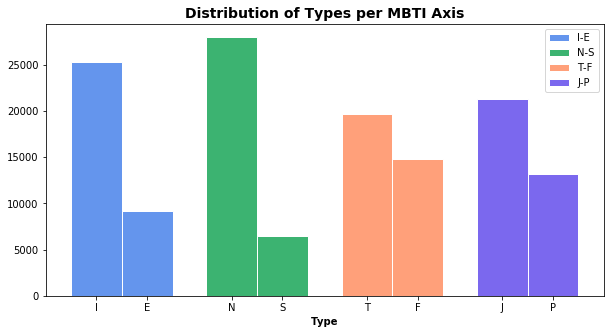

In [568]:
tmp_data1 = pd.DataFrame(df['I-E'].value_counts().reset_index().rename({'I-E': 'freq.'}, axis=1))
tmp_data2 = pd.DataFrame(df['N-S'].value_counts().reset_index().rename({'N-S': 'freq.'}, axis=1))
tmp_data3 = pd.DataFrame(df['T-F'].value_counts().reset_index().rename({'T-F': 'freq.'}, axis=1))
tmp_data4 = pd.DataFrame(df['J-P'].value_counts().reset_index().rename({'J-P': 'freq.'}, axis=1))

bar_width = 0.3
spacer_ls = np.arange(0.1, stop=0.5, step=0.3)
plt.figure(figsize=(10, 5))

plt.title('Distribution of Types per MBTI Axis', fontsize=14, fontweight='bold')
plt.bar(spacer_ls, tmp_data1['freq.'], color=['cornflowerblue'], width=bar_width, edgecolor='white', label='var1')
plt.bar(spacer_ls+0.8, tmp_data2['freq.'], color='mediumseagreen', width=bar_width, edgecolor='white', label='var2')
plt.bar(spacer_ls+1.6, tmp_data3['freq.'], color='lightsalmon', width=bar_width, edgecolor='white', label='var3')
plt.bar(spacer_ls+2.4, tmp_data4['freq.'], color='mediumslateblue', width=bar_width, edgecolor='white', label='var4')

plt.xlabel('Type', fontweight='bold')
plt.xticks([spacer_ls[0], spacer_ls[1], (spacer_ls[0]+0.8), (spacer_ls[1]+0.8),
            (spacer_ls[0]+1.6), (spacer_ls[1]+1.6), (spacer_ls[0]+2.4), (spacer_ls[1]+2.4)],
           ['I', 'E', 'N', 'S', 'T', 'F', 'J', 'P'])
 
plt.legend(['I-E', 'N-S', 'T-F',  'J-P'])
plt.show()

<b>Observation(s):<b><br>
*  Although, the distribution for T-F axis and J-P axis is slightly different, the distribution for I-E axis and N-S axis is very different which demands our attention. We will fix this issue later, after the feature extraction stage.
*  This is much better than the previous distribution of types. Before, we need to deal with 16 imbalanced classes, now, we only need to addressed 8 imbalanced classes.

### 3.1.4 Check the Correlation between the 4 types

We will check the correlation between the 4 major axis of MBTI before we can use it.
Correlation in our independent variables can be a problem during the modeling phase because it will be difficult for our model to estimate the relationship between our dependent variables and independent variables independently. 
<br>

ie. As the probability of a person being an Introvert increases, the probability of him being a Thinker decreases. We can say that there is a negative correlation between the two variables, and it will be hard for our model to estimate how introvert a person is, versus how thinker a person is, <i>independently</i>.

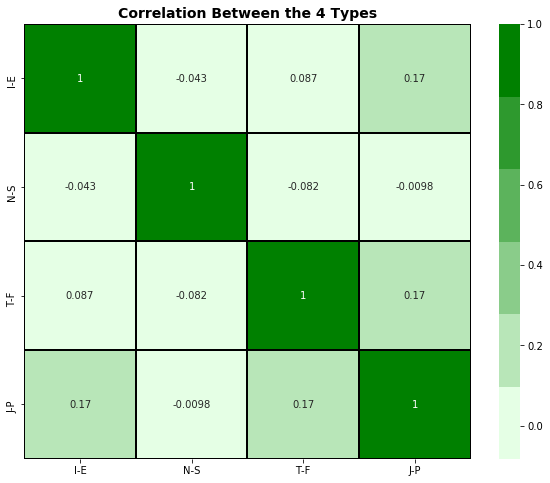

In [582]:
plt.figure(figsize=(10, 8))
plt.title('Correlation Between the 4 Types', fontsize=14, fontweight='bold')
corr = df[['I-E', 'N-S', 'T-F',  'J-P']].corr()
sns.heatmap(data=corr, annot=True, linewidths=1, linecolor='black',
            cmap=sns.light_palette("green"))
plt.show()

<b>Observation(s):<b>
*  The correlation between the 4 types is close to zero, which means there is a very little correlation between those variables, and this is good.

## 3.2 Feature Analysis

### 3.2.1 Text Analysis

### 3.2.2 Feature Extraction

Given that we are going to use a feature in the form of text data, we can first extract the features from the text data and then analyze it later. 

<br>
Following is the list of my plan on how I will attack the feature extraction phase:<br>

1.) 
<br>2.)

In [2]:
df_16p_disc = pd.read_csv('../output/comment_discussion.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df_16p_disc = df_16p_disc[['sub-profileUrl', 'sub-answerBody', 'sub-type', 'sub-approvedAtNice']]
df_16p_disc = df_16p_disc.drop(axis=1, index=df_16p_disc[df_16p_disc['sub-answerBody'].isna()].index)
df_16p_disc['sub-type'] = df_16p_disc['sub-type'].fillna('Anonymous')
# df_16p_disc['sub-approvedAtNice'] = pd.to_timedelta(pd.to_datetime(df_16p_disc['sub-approvedAtNice'], utc=True).apply(lambda x: datetime.strftime(x, '%H:%M:%S')))

In [229]:
temp_df = df_16p_disc.groupby(['sub-profileUrl', 'sub-type']).agg({'sub-answerBody': '|||'.join,
'sub-approvedAtNice': lambda x: x.median()}).reset_index()

In [50]:
df_16p_disc[(df_16p_disc['sub-profileUrl'] == '00694a4b6c6de')]

,sub-profileUrl,sub-answerBody,sub-type,sub-approvedAtNice
403051,00694a4b6c6de,"Favorite Book/Movie/TV Show: Doctor Who, The W...",ENFJ,14:42:00
414785,00694a4b6c6de,"This is my first day, but I am hoping to chang...",ENFJ,02:55:00


In [179]:
# df_16p_disc['x'] = pd.to_datetime(df_16p_disc['sub-approvedAtNice'])

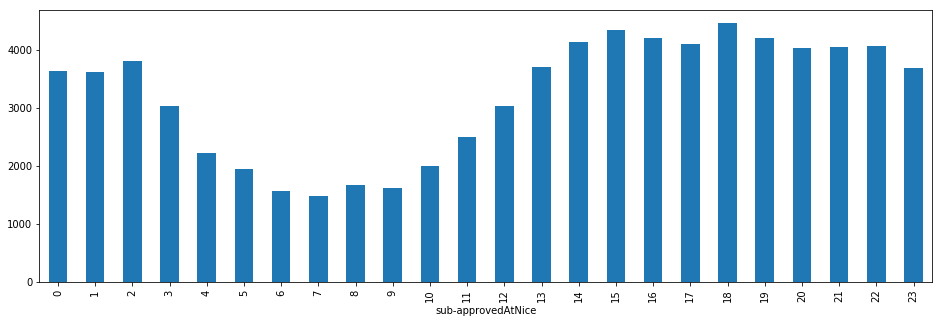

In [199]:
z = df_16p_disc[df_16p_disc['sub-type'] == 'INTJ']
plt.figure(figsize=(16, 5))
z['sub-approvedAtNice'].groupby([z['sub-approvedAtNice'].dt.seconds//3600]).count().plot(kind='bar')

In [203]:
temp_df['H'] = temp_df['sub-approvedAtNice'].dt.seconds//3600

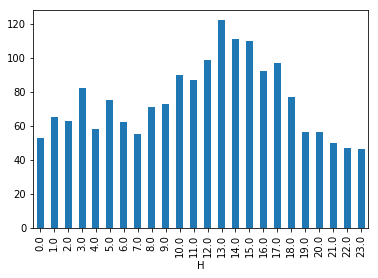

In [214]:
temp_df.where(temp_df['sub-type']=='INTP').groupby('H').count()['sub-type'].plot(kind='bar')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


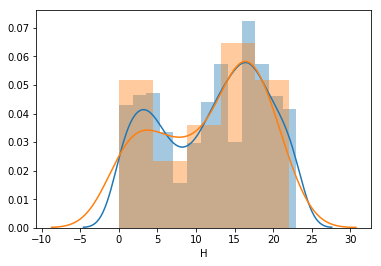

In [236]:
x = temp_df.copy()
x['H'] = x['sub-approvedAtNice'].dt.seconds//3600
sns.distplot(x.loc[x['sub-type'] == 'INFP', 'H'])
sns.distplot(x.loc[x['sub-type'] == 'ESTJ','H'])

In [239]:
df_16p_disc['sub-answerBody'].apply(lambda x: len(x)).mean()

493.551804396807

In [242]:
df_16p_disc['sub-answerBody'].apply(lambda x: len(x)).argmax()

327743

In [3]:
import utils, re

def replace_alias(string):
    return re.sub('\*', ' ', string).strip()

def remove_html_tags(string):
    return re.sub('<.+?>', ' ', string).strip()

def decontracted(string):
    # https://stackoverflow.com/a/47091490/4084039

    # specific
    phrase = re.sub(r"won't", "will not", string)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def replace_emoji(samp):
    samp = samp.lower().replace(r':)', '[smile-emoji]')
    samp = samp.lower().replace(r'◠‿◠✿', '[smile-emoji]')
    samp = samp.lower().replace(':p', '[tongue-out-emoji]')
    samp = samp.lower().replace(':d', '[big-smile-emoji]')
    return samp

In [4]:
import string
import nltk
from nltk.corpus import stopwords
STOPWORDS = stopwords.words()
STOPWORDS.remove('not')

In [ ]:
# TODO: Replace emoji before striping html elements
df_16p_disc['sub-answerBody'] = df_16p_disc['sub-answerBody'].apply(remove_html_tags)
df_16p_disc['sub-answerBody'] = df_16p_disc['sub-answerBody'].apply(replace_alias)
df_16p_disc['sub-answerBody'] = df_16p_disc['sub-answerBody'].apply(decontracted)
df_16p_disc['sub-answerBody'] = df_16p_disc['sub-answerBody'].apply(replace_emoji)
df_16p_disc['sub-answerBody'] = df_16p_disc['sub-answerBody'].apply(lambda x: ' '.join([word.lower() for word in nltk.word_tokenize(x) if word.isalpha()]))
df_16p_disc['sub-answerBody'] = df_16p_disc['sub-answerBody'].apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS]))

In [3]:
len("'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments https://www.youtube.com/watch?v=iz7lE1g4XM4 sportscenter not top ten plays https://www.youtube.com/watch?v=uCdfze1etec pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8 http://www.youtube.com/watch?v=u8ejam5DP3E On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~ http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389 84390 http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...|||Welcome and stuff.|||http://playeressence.com/wp-content/uploads/2013/08/RED-red-the-pokemon-master-32560474-450-338.jpg Game. Set. Match.|||Prozac, wellbrutin, at least thirty minutes of moving your legs (and I don't mean moving them while sitting in your same desk chair), weed in moderation (maybe try edibles as a healthier alternative...|||Basically come up with three items you've determined that each type (or whichever types you want to do) would more than likely use, given each types' cognitive functions and whatnot, when left by...|||All things in moderation. Sims is indeed a video game, and a good one at that. Note: a good one at that is somewhat subjective in that I am not completely promoting the death of any given Sim...|||Dear ENFP: What were your favorite video games growing up and what are your now, current favorite video games? :cool:|||https://www.youtube.com/watch?v=QyPqT8umzmY|||It appears to be too late. :sad:|||There's someone out there for everyone.|||Wait... I thought confidence was a good thing.|||I just cherish the time of solitude b/c i revel within my inner world more whereas most other time i'd be workin... just enjoy the me time while you can. Don't worry, people will always be around to...|||Yo entp ladies... if you're into a complimentary personality,well, hey.|||... when your main social outlet is xbox live conversations and even then you verbally fatigue quickly.|||http://www.youtube.com/watch?v=gDhy7rdfm14 I really dig the part from 1:46 to 2:50|||http://www.youtube.com/watch?v=msqXffgh7b8|||Banned because this thread requires it of me.|||Get high in backyard, roast and eat marshmellows in backyard while conversing over something intellectual, followed by massages and kisses.|||http://www.youtube.com/watch?v=Mw7eoU3BMbE|||http://www.youtube.com/watch?v=4V2uYORhQOk|||http://www.youtube.com/watch?v=SlVmgFQQ0TI|||Banned for too many b's in that sentence. How could you! Think of the B!|||Banned for watching movies in the corner with the dunces.|||Banned because Health class clearly taught you nothing about peer pressure.|||Banned for a whole host of reasons!|||http://www.youtube.com/watch?v=IRcrv41hgz4|||1) Two baby deer on left and right munching on a beetle in the middle. 2) Using their own blood, two cavemen diary today's latest happenings on their designated cave diary wall. 3) I see it as...|||a pokemon world an infj society everyone becomes an optimist|||49142|||http://www.youtube.com/watch?v=ZRCEq_JFeFM|||http://discovermagazine.com/2012/jul-aug/20-things-you-didnt-know-about-deserts/desert.jpg|||http://oyster.ignimgs.com/mediawiki/apis.ign.com/pokemon-silver-version/d/dd/Ditto.gif|||http://www.serebii.net/potw-dp/Scizor.jpg|||Not all artists are artists because they draw. It's the idea that counts in forming something of your own... like a signature.|||Welcome to the robot ranks, person who downed my self-esteem cuz I'm not an avid signature artist like herself. :proud:|||Banned for taking all the room under my bed. Ya gotta learn to share with the roaches.|||http://www.youtube.com/watch?v=w8IgImn57aQ|||Banned for being too much of a thundering, grumbling kind of storm... yep.|||Ahh... old high school music I haven't heard in ages. http://www.youtube.com/watch?v=dcCRUPCdB1w|||I failed a public speaking class a few years ago and I've sort of learned what I could do better were I to be in that position again. A big part of my failure was just overloading myself with too...|||I like this person's mentality. He's a confirmed INTJ by the way. http://www.youtube.com/watch?v=hGKLI-GEc6M|||Move to the Denver area and start a new life for myself.'")

4630